In [1]:
%pip install -r ../../requirements.txt

  Using cached BindsNET-0.2.9-py3-none-any.whl
  Using cached gym-0.18.0-py3-none-any.whl


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.14/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [111]:
import argparse
import torch
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes
from bindsnet.network.monitors import Monitor
from bindsnet.network.nodes import AbstractInput
from bindsnet.network.topology import (
    AbstractConnection,
    Connection,
    Conv2dConnection,
    LocalConnection,
)
from bindsnet.utils import im2col_indices
from bindsnet.learning import LearningRule
from bindsnet.analysis.plotting import plot_spikes

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gym
from bindsnet.environment import GymEnvironment
from typing import Union, Optional, Sequence, Tuple
from collections import deque
from statistics import mean
from torch import Tensor
from collections import namedtuple

In [84]:
Args = namedtuple('Args', ['gamma', 'env', 'n_episode', 'hidden_dim'])
FLAGS = Args(gamma=0.99, env='BreakoutDeterministic-v4', n_episode=1000, hidden_dim=12)

In [85]:
s_im, s_ax = None, None

In [103]:
class Tau:
    def __init__(self):
        self.data = pd.read_csv('./article_ephys_metadata_curated.csv', sep="	")
        self.data = self.data["tau"].dropna()
        self.tau_distribution = self.data.to_numpy()

    def get_distribution(self):
        return self.tau_distribution

    def sample(self, number):
        return torch.tensor([np.random.choice(self.tau_distribution) for x in range(number)])

In [104]:
class HMSTDP(LearningRule):
    # language=rst
    """
    Heterogeneous Reward-modulated STDP. Built on the MSTDP algorithm from `(Florian 2007)
    <https://florian.io/papers/2007_Florian_Modulated_STDP.pdf>`_.
    """

    def __init__(
        self,
        connection: AbstractConnection,
        nu: Optional[Union[float, Sequence[float]]] = None,
        reduction: Optional[callable] = None,
        weight_decay: float = 0.0,
        **kwargs
    ) -> None:
        # language=rst
        """
        Constructor for ``MSTDP`` learning rule.

        :param connection: An ``AbstractConnection`` object whose weights the ``MSTDP``
            learning rule will modify.
        :param nu: Single or pair of learning rates for pre- and post-synaptic events,
            respectively.
        :param reduction: Method for reducing parameter updates along the minibatch
            dimension.
        :param weight_decay: Constant multiple to decay weights by on each iteration.

        Keyword arguments:

        :param tc_plus: Array of time constants for pre-synaptic firing trace. Same size as the connection source.
        :param tc_minus: Time constant for post-synaptic firing trace. Same size as the connection target.
        """
        super().__init__(
            connection=connection,
            nu=nu,
            reduction=reduction,
            weight_decay=weight_decay,
            **kwargs
        )

        if isinstance(connection, (Connection, LocalConnection)):
            self.update = self._connection_update
        elif isinstance(connection, Conv2dConnection):
            self.update = self._conv2d_connection_update
        else:
            raise NotImplementedError(
                "This learning rule is not supported for this Connection type."
            )

        self.tau = Tau()
        self.tc_plus = torch.tensor(kwargs.get("tc_plus", self.tau.sample(self.connection.source.n)))
        self.tc_minus = torch.tensor(kwargs.get("tc_minus", self.tau.sample(self.connection.target.n)))

    def _connection_update(self, **kwargs) -> None:
        # language=rst
        """
        HMSTDP learning rule for ``Connection`` subclass of ``AbstractConnection`` class.

        Keyword arguments:

        :param Union[float, torch.Tensor] reward: Reward signal from reinforcement
            learning task.
        :param float a_plus: Learning rate (post-synaptic).
        :param float a_minus: Learning rate (pre-synaptic).
        """
        batch_size = self.source.batch_size

        # Initialize eligibility, P^+, and P^-.
        if not hasattr(self, "p_plus"):
            self.p_plus = torch.zeros(batch_size, *self.source.shape)
        if not hasattr(self, "p_minus"):
            self.p_minus = torch.zeros(batch_size, *self.target.shape)
        if not hasattr(self, "eligibility"):
            self.eligibility = torch.zeros(batch_size, *self.connection.w.shape)

        # Reshape pre- and post-synaptic spikes.
        source_s = self.source.s.view(batch_size, -1).float()
        target_s = self.target.s.view(batch_size, -1).float()
        # Parse keyword arguments.
        reward = kwargs["reward"]
        a_plus = torch.tensor(kwargs.get("a_plus", 1.0))
        a_minus = torch.tensor(kwargs.get("a_minus", -1.0))

        # Compute weight update based on the eligibility value of the past timestep.
        update = reward * self.eligibility
        self.connection.w += self.nu[0] * self.reduction(update, dim=0)

        # Update P^+ and P^- values.
        self.p_plus *= torch.exp(-self.connection.dt / self.tc_plus)
        self.p_plus += a_plus * source_s
        self.p_minus *= torch.exp(-self.connection.dt / self.tc_minus)
        self.p_minus += a_minus * target_s

        # Calculate point eligibility value.
        self.eligibility = torch.bmm(
            self.p_plus.unsqueeze(2), target_s.unsqueeze(1)
        ) + torch.bmm(source_s.unsqueeze(2), self.p_minus.unsqueeze(1))

        super().update()

    def _conv2d_connection_update(self, **kwargs) -> None:
        # language=rst
        """
        MSTDP learning rule for ``Conv2dConnection`` subclass of ``AbstractConnection``
        class.

        Keyword arguments:

        :param Union[float, torch.Tensor] reward: Reward signal from reinforcement
            learning task.
        :param float a_plus: Learning rate (post-synaptic).
        :param float a_minus: Learning rate (pre-synaptic).
        """
        batch_size = self.source.batch_size

        # Initialize eligibility.
        if not hasattr(self, "eligibility"):
            self.eligibility = torch.zeros(batch_size, *self.connection.w.shape)

        # Parse keyword arguments.
        reward = kwargs["reward"]
        a_plus = torch.tensor(kwargs.get("a_plus", 1.0))
        a_minus = torch.tensor(kwargs.get("a_minus", -1.0))

        batch_size = self.source.batch_size

        # Compute weight update based on the eligibility value of the past timestep.
        update = reward * self.eligibility
        self.connection.w += self.nu[0] * torch.sum(update, dim=0)

        out_channels, _, kernel_height, kernel_width = self.connection.w.size()
        padding, stride = self.connection.padding, self.connection.stride

        # Initialize P^+ and P^-.
        if not hasattr(self, "p_plus"):
            self.p_plus = torch.zeros(batch_size, *self.source.shape)
            self.p_plus = im2col_indices(
                self.p_plus, kernel_height, kernel_width, padding=padding, stride=stride
            )
        if not hasattr(self, "p_minus"):
            self.p_minus = torch.zeros(batch_size, *self.target.shape)
            self.p_minus = self.p_minus.view(batch_size, out_channels, -1).float()

        # Reshaping spike occurrences.
        source_s = im2col_indices(
            self.source.s.float(),
            kernel_height,
            kernel_width,
            padding=padding,
            stride=stride,
        )
        target_s = self.target.s.view(batch_size, out_channels, -1).float()

        # Update P^+ and P^- values.
        self.p_plus *= torch.exp(-self.connection.dt / self.tc_plus)
        self.p_plus += a_plus * source_s
        self.p_minus *= torch.exp(-self.connection.dt / self.tc_minus)
        self.p_minus += a_minus * target_s

        # Calculate point eligibility value.
        self.eligibility = torch.bmm(
            target_s, self.p_plus.permute((0, 2, 1))
        ) + torch.bmm(self.p_minus, source_s.permute((0, 2, 1)))
        self.eligibility = self.eligibility.view(self.connection.w.size())

        super().update()

In [105]:
class SQN(object):
    def __init__(self, input_dim: int, shape: [int], output_dim: int, hidden_dim: int) -> None:
        """SQN Network
        """
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.network = Network(dt=1.0)
        self.learning_rule = HMSTDP
        self.time = int(self.network.dt)
        self.input = Input(n=input_dim, traces=True)
        

        # Heterogeneous LIFNodes
        self.hidden = LIFNodes(n=hidden_dim, traces=True)
        self.output = LIFNodes(n=output_dim, traces=True)

        # First connection
        self.connection_input_hidden = Connection(
            source=self.input,
            target=self.hidden,
            update_rule=self.learning_rule,
            wmin=0,
            wmax=1,
            nu=FLAGS.gamma
        )

        # Hidden recurrent connection
        self.connection_hidden_hidden = Connection(
            source=self.hidden,
            target=self.hidden,
            update_rule=self.learning_rule,
            wmin=0,
            wmax=1,
            nu=FLAGS.gamma
        )

        # Hidden layer to Output
        self.connection_hidden_output = Connection(
            source=self.hidden,
            target=self.output,
            update_rule=self.learning_rule,
            wmin=0,
            wmax=1,
            nu=FLAGS.gamma
        )

        self.network.add_layer(
            layer=self.input, name="Input"
        )
        self.network.add_layer(
            layer=self.hidden, name="Hidden"
        )
        self.network.add_layer(
            layer=self.output, name="Output"
        )

        self.network.add_connection(
            connection=self.connection_input_hidden,
            source="Input",
            target="Hidden"
        )
        self.network.add_connection(
            connection=self.connection_hidden_hidden,
            source="Hidden",
            target="Hidden"
        )
        self.network.add_connection(
            connection=self.connection_hidden_output,
            source="Hidden",
            target="Output"
        )

        self.inputs = [
            name
            for name, layer in self.network.layers.items()
            if isinstance(layer, AbstractInput)
        ]

        # To record outputs
        self.network.add_monitor(
            Monitor(self.output, ["s"], time=self.time),
            name="output_monitor"
        )
        self.network.add_monitor(
            Monitor(self.hidden, ["s"], time=self.time),
            name="hidden_monitor"
        )
        self.network.add_monitor(
            Monitor(self.input, ["s"], time=self.time),
            name="input_monitor"
        )

        self.spike_record = {
            "Output": torch.zeros((self.time, output_dim)).to(
                self.device
            )
        }

    def run(self, inputs: dict[str, torch.Tensor], reward: [float, torch.Tensor], **kwargs) -> None:
        self.network.train(mode=True)
        return self.network.run(inputs=inputs, time=self.time, reward=reward, **kwargs)

In [106]:
class Agent(object):
    def __init__(self, input_dim: int, shape: [int], output_dim: int, hidden_dim: int) -> None:
        """Agent class that chooses an action and trains
        """
        self.sqn = SQN(input_dim, shape, output_dim, hidden_dim)
        self.input_dim = input_dim
        self.output_dim = output_dim

    def get_action(self) -> int:
        """Returns an action index
        """
        scores = self.get_Q()
        probabilities = torch.softmax(scores, dim=0)
        return torch.multinomial(probabilities, num_samples=1).item()

        _, argmax = torch.max(torch.flatten(scores), dim=0)
        # print(torch.flatten(scores), argmax.item())

        # if np.random.rand() < 0.2:
        #     return np.random.choice(self.output_dim)
        # else:
        return argmax.item()

    def get_Q(self) -> Tensor:
        """Returns `Q-value` based on output layer's spikes
        """
        return torch.sum(self.sqn.spike_record["Output"], dim=0)

In [107]:
def play_episode(env: GymEnvironment, agent: Agent) -> int:
    """Play an epsiode and train
    Args:
        env (gym.Env): gym environment (CartPole-v0)
        agent (Agent): agent will train and get action
    Returns:
        int: reward
    """
    env.reset()
    agent.sqn.network.reset_state_variables()

    done = False
    total_reward = 0

    while not done:
        env.render()
        # Select an action
        a = agent.get_action()
        # Update the state according to action a
        s, r, done, info = env.step(a)

        r = clip_reward(r)

        # Tensor shape configuration
        s = s.flatten()

        s_shape = [1] * len(s.shape[1:])

        # Run the agent for time t on state s with reward r
        inputs = {k: s.repeat(agent.sqn.time, *s_shape) for k in agent.sqn.inputs}
        agent.sqn.run(inputs=inputs, reward=r)

        # Update output spikes
        if agent.sqn.output is not None:
            agent.sqn.spike_record["Output"] = (
                agent.sqn.network.monitors["output_monitor"].get("s").float()
            )

        total_reward += r

        global s_im
        global s_ax
        s_im, s_ax = plot_spikes({
            "input": agent.sqn.network.monitors["input_monitor"].get("s"),
            "hidden": agent.sqn.network.monitors["hidden_monitor"].get("s"),
            "output": agent.sqn.network.monitors["output_monitor"].get("s")
        }, ims=s_im, axes=s_ax)

    return total_reward

In [108]:
def get_env_dim(env: gym.Env) -> Tuple[int, int]:
    """Returns input_dim & output_dim
    Args:
        env (gym.Env): gym Environment
    Returns:
        int: input_dim
        int: output_dim
    """
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    return input_dim, output_dim

In [109]:
def clip_reward(reward):
    """Clip reward so that it's in [-1, 1]
    """
    if reward < -1:
        reward = -1
    elif reward > 1:
        reward = 1
    return reward

[Episode:     1] Reward:   0.0


KeyboardInterrupt: 

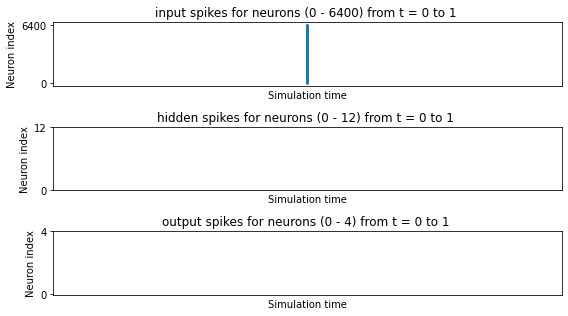

In [112]:
try:
    env = GymEnvironment(FLAGS.env)

    average_rewards = []
    q = deque(maxlen=100)

    input_dim, output_dim = get_env_dim(env.env)
    agent = Agent(80 * 80, [1, 1, 80, 80], output_dim, FLAGS.hidden_dim)

    for i in range(FLAGS.n_episode):
        r = play_episode(env, agent)
        print("[Episode: {:5}] Reward: {:5}".format(i + 1, r))

        q.append(r)
        if i % 100 == 0:
            average_rewards.append(mean(q))

    name = "SQN-HMSTDP-{}-{}-{}-reward_clamping".format( FLAGS.env, FLAGS.n_episode, FLAGS.gamma)

    fig, ax = plt.subplots()
    ax.plot(average_rewards)

    ax.set(xlabel='Episode', ylabel='Reward',
           title='SQN performance with {} on {}'.format(FLAGS.update_rule, FLAGS.env))
    plt.show()


finally:
    env.close()